# Chapter 3 - Regression Models 
## Segment 3 - Logistic regression

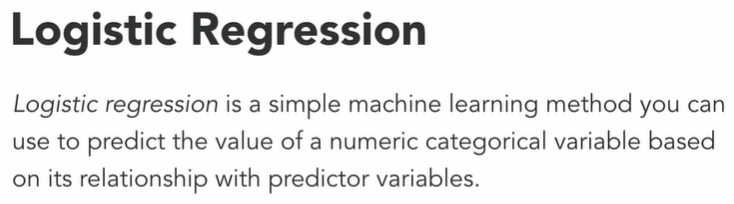

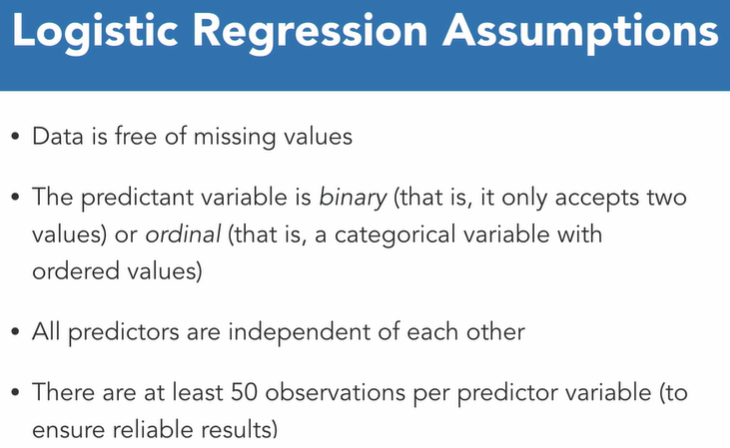

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

## Logistic regression on the titanic dataset

In [8]:
address = r"C:\Users\Andre\Desktop\Projects\ecourses\PythonDataSci2\titanic-training-data.csv"
titanic_training = pd.read_csv(address)
#titanic_training.columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
print(titanic_training.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [9]:
print(titanic_training.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


#### Cabin, Age and Embarked have missing values

##### VARIABLE DESCRIPTIONS

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

# Lets test for the assumptions

### Checking that your target variable (Survived) is binary

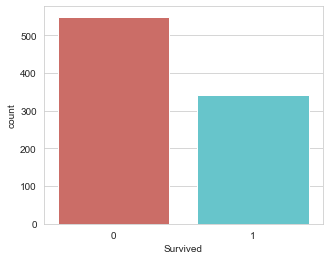

In [11]:
sb.countplot(x='Survived', data=titanic_training, palette='hls')

Binary!!!

### Checking for missing values

another way to check

In [14]:
titanic_training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
titanic_training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Cabin value is almost all missing. So lets drop it.

For Age we should find a way to make an approximation.

### Taking care of missing values
##### Dropping missing values
So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
- Survived - This variable is obviously relevant.
- Pclass - Does a passenger's class on the boat affect their survivability?
- Sex - Could a passenger's gender impact their survival rate?
- Age - Does a person's age impact their survival rate?
- SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
- Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
- Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
- Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [16]:
### new data set with dropped values
titanic_data = titanic_training.drop(['Name', 'Ticket', 'Cabin'], axis=1)

### Imputing missing values

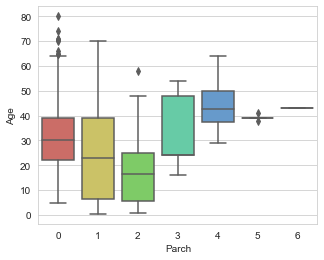

In [17]:
sb.boxplot(x='Parch', y='Age', data = titanic_data, palette='hls')

The older a person the most likely to have parch on the boat

In [19]:
## everage age per parch per category
parch_groups = titanic_data.groupby(titanic_data['Parch'])
parch_groups.mean()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,,
0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


0 children or parents average age is 32.
1 avergage age is 24
2 17
3 33
4 44
5 39
6 43

In [20]:
def age_aprox(cols):
    Age = cols[0]
    Parch = cols[1]
    
    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return 30 ## average general age

In [22]:
### lets compute the function into the data
titanic_data['Age']= titanic_data[['Age', 'Parch']].apply(age_approx, axis=1)

In [23]:
### Now checking for missing Values
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

In [24]:
### for embarked. we could just drop the missing records

In [25]:
titanic_data.dropna(inplace=True)
titanic_data.reset_index(inplace=True, drop=True)

print(titanic_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.6+ KB
None


Now no missing values!!

### Converting categorical variables to a dummy indicators

In [26]:
### put sex and embarked into numeric variables

In [27]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
gender_cat = titanic_data['Sex']
gender_encoded = label_encoder.fit_transform(gender_cat)
gender_encoded[0:5]

array([1, 0, 0, 0, 1])

In [28]:
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [29]:
# 1 = male and 0 = female
gender_DF = pd.DataFrame(gender_encoded, columns=['male_gender'])
gender_DF.head()

,male_gender
0,1
1,0
2,0
3,0
4,1


In [30]:
embarked_cat = titanic_data['Embarked']
embarked_encoded = label_encoder.fit_transform(embarked_cat)

embarked_encoded[0:100]

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2,
       1, 2, 2, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0,
       1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2])

#### embarked is now numerical categorical too
Buut is not Binary.. Soo One Hot Encoder is needed!!

One hot encoder creates 3 separate columns for each of the categories

In [33]:
from sklearn.preprocessing import OneHotEncoder
binary_encoder = OneHotEncoder(categories='auto')
embarked_1hot = binary_encoder.fit_transform(embarked_encoded.reshape(-1,1))
embarked_1hot_mat = embarked_1hot.toarray()
embarked_DF = pd.DataFrame(embarked_1hot_mat, columns = ['C','Q','S'])
embarked_DF.head()

,C,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


Now we have a binary variable that represents where people boarde the boat

In [35]:
titanic_data.drop(['Sex','Embarked'], axis =1, inplace=True)
### we drop them because now they are encoded!!
titanic_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [37]:
# Lets join our encoded columns to our data.
titanic_dmy = pd.concat([titanic_data, gender_DF, embarked_DF], axis=1, verify_integrity=True).astype(float)
titanic_dmy[0:5]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male_gender,C,Q,S
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,1.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0


Data is Ready!!

### Checking for independence between features

We can use a heatmap to check for independence

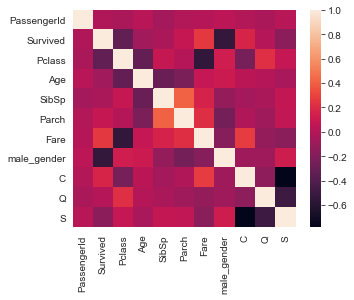

In [38]:
sb.heatmap(titanic_dmy.corr())

We cant have values that are too light or too dark

- Fare and Class are highly correlated, so lets drop one

In [43]:
titanic_dmy.drop(['Fare'],axis=1, inplace=True)


KeyError: "['Fare'] not found in axis"

In [44]:
titanic_dmy.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,male_gender,C,Q,S
0,1.0,0.0,3.0,22.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2.0,1.0,1.0,38.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,1.0,3.0,26.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5.0,0.0,3.0,35.0,0.0,0.0,1.0,0.0,0.0,1.0


### Checking that your dataset size is sufficient

We need to consider how many predictive variables I have 7.
Rule of thumb is 50 records per predictive feature. 50x7 = 350. we good, we have 889

### Break data into training and test

In [46]:
X_train, X_test, y_train, y_test = train_test_split(titanic_dmy.drop('Survived',axis=1),
                                                   titanic_dmy['Survived'], test_size=0.2,
                                                   random_state=200)

In [47]:
### lets look at the shape of our outputs

print(X_train.shape)
print(y_train.shape)

(711, 9)
(711,)


In [48]:
X_train[0:5]

,PassengerId,Pclass,Age,SibSp,Parch,male_gender,C,Q,S
719,721.0,2.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0
165,167.0,1.0,24.0,0.0,1.0,0.0,0.0,0.0,1.0
879,882.0,3.0,33.0,0.0,0.0,1.0,0.0,0.0,1.0
451,453.0,1.0,30.0,0.0,0.0,1.0,1.0,0.0,0.0
181,183.0,3.0,9.0,4.0,2.0,1.0,0.0,0.0,1.0


### Deploying and evaluating the model

In [49]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
y_pred = LogReg.predict(X_test)

## Model Evaluation
### Classification report without cross-validation

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87       109
         1.0       0.84      0.70      0.76        69

    accuracy                           0.83       178
   macro avg       0.83      0.81      0.82       178
weighted avg       0.83      0.83      0.83       178



In [52]:
##precision and averages of ~ 83% NOT BAD

### K-fold cross-validation & confusion matrices

In [53]:
y_train_pred = cross_val_predict(LogReg, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[384,  56],
       [ 90, 181]], dtype=int64)

In [54]:
### 384 and 181 are the number of correct predictions. 56 and 90. incorrect

In [55]:
### to generate a precision score
precision_score(y_train, y_train_pred)

0.7637130801687764

76% precision

### Make a test prediction

In [58]:
### lets look at an example passenger
titanic_dmy[863:864]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,male_gender,C,Q,S
863,866.0,1.0,2.0,42.0,0.0,0.0,0.0,0.0,0.0,1.0


In [60]:
### now a test passenger - simmilar to example
test_passenger = np.array([866, 2, 40, 0, 0, 0, 0 ,0 ,1]).reshape(1,-1)

print(LogReg.predict(test_passenger))
print(LogReg.predict_proba(test_passenger))

[1.]
[[0.24588707 0.75411293]]


In [61]:
### The model predicts that the person will survive